In [1]:
#we will rely on ROOT data analysis framework for fitting
import ROOT

Welcome to JupyROOT 6.10/06


Binned maximum likelihood fitting is much faster than unbinned maximum likelihood fitting.

We will use histograms as PDF yielding n = (n1,n2,n3,...,nN) in N bins.

In [2]:
from ROOT import TChain, TFile, TH1F, TCanvas
from math import *

names = ["ttbar","wjets","dy","data"]

for name in names:
    # open the file
    chain = TChain("events");
    chain.Add('files/'+name+'.root')

    f = TFile('hist_'+name+'.root', 'RECREATE')

    h_njets = TH1F('h_njets','number of jets',10,0.0,10.0)


    entries = chain.GetEntries()
    for i in xrange(entries):
        chain.GetEntry(i)
        #met = math.sqrt( chain.MET_px**2 + chain.MET_py**2 ) # we can use missing energy to remove Z boson events
        if chain.NMuon > 1:
            h_njets.Fill(chain.NJet, chain.EventWeight)

    ntotal = h_njets.Integral()
    print "total number of events from ", name , "= ", "%.1f" % ntotal, "(raw events = ", entries , ")"

    f.Write()
    f.Close()

total number of events from  ttbar =  65.9 (raw events =  36941 )
total number of events from  wjets =  2.5 (raw events =  109737 )
total number of events from  dy =  19254.3 (raw events =  77729 )
total number of events from  data =  18708.0 (raw events =  469384 )


In [3]:
ls *.root

hist_data.root  histdata.root  hist_dy.root  hist_ttbar.root  hist_wjets.root


##### answer :

```
hist_data.root  hist_dy.root  hist_ttbar.root  hist_wjets.root
```

Now we will read the histograms. 

In [4]:
from ROOT import TChain, TFile, TH1F, TCanvas

f_data = TFile("hist_data.root")
f_dy = TFile("hist_dy.root")
f_wjets = TFile("hist_wjets.root")
f_ttbar = TFile("hist_ttbar.root")

h_data = f_data.Get("h_njets")
h_dy = f_dy.Get("h_njets")
h_wjets = f_wjets.Get("h_njets")
h_ttbar = f_ttbar.Get("h_njets")

And check how many bins we have in the histogram.

In [5]:
nbins = h_data.GetXaxis().GetNbins()
print nbins

10


##### answer:

```
10
```

We will use RooStats for the binned likelihood fitting. We don't need to worry about this part. 
We will just import necessary library and set the variable and histograms in this RooStats format.  

In [6]:
from ROOT import RooRealVar, RooDataHist, RooArgList
x = RooRealVar("x","x", 0, 10) 
data = RooDataHist("data","data", ROOT.RooArgList(x), h_data) 
ttbar = RooDataHist("ttbar","ttbar", ROOT.RooArgList(x), h_ttbar) 
dy = RooDataHist("zjets","zjets", ROOT.RooArgList(x), h_dy) 
wjets = RooDataHist("wjets","wjets", ROOT.RooArgList(x), h_wjets) 


RooFit v3.60 -- Developed by Wouter Verkerke and David Kirkby 
                Copyright (C) 2000-2013 NIKHEF, University of California & Stanford University
                All rights reserved, please read http://roofit.sourceforge.net/license.txt

[#1] INFO:DataHandling -- RooDataHist::adjustBinning(data): fit range of variable x expanded to nearest bin boundaries: [0,10] --> [0,10]
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(ttbar): fit range of variable x expanded to nearest bin boundaries: [0,10] --> [0,10]
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(zjets): fit range of variable x expanded to nearest bin boundaries: [0,10] --> [0,10]
[#1] INFO:DataHandling -- RooDataHist::adjustBinning(wjets): fit range of variable x expanded to nearest bin boundaries: [0,10] --> [0,10]


We will need to make templates for each process. 

In [7]:
from ROOT import RooHistPdf
pdf_ttbar = RooHistPdf("pdf_ttbar","pdf_ttbar", ROOT.RooArgSet(x), ttbar) 
pdf_dy = RooHistPdf("pdf_dy","pdf_dy", ROOT.RooArgSet(x), dy) 
pdf_wjets = RooHistPdf("pdf_wjets","pdf_wjets", ROOT.RooArgSet(x), wjets) 

create parameter and initialize it

In [8]:
nttbar = RooRealVar("nttbar","nttbar",200, 0, 10000)
ndy = RooRealVar("ndy","ndy", 20000 , 0, 40000) 
nwjets = RooRealVar("nwjets","nwjets", 300 , 0, 10000) 

create a model

extended likelihood model below

$$ M(x) = N_{ttbar} \cdot S_{ttbar} (x) + N_{dy} \cdot B_{dy} (x) + N_{wjets} \cdot B_{wjets} (x)  $$

In [9]:
from ROOT import RooAddPdf
model = RooAddPdf("model","model",RooArgList(pdf_ttbar, pdf_dy, pdf_wjets), RooArgList(nttbar, ndy, nwjets))

perform the fit

In [10]:
fitResult = model.fitTo( data );

[#1] INFO:Minization -- p.d.f. provides expected number of events, including extended term in likelihood.
[#1] INFO:Minization -- RooMinimizer::optimizeConst: activating const optimization
[#1] INFO:Minization --  The following expressions have been identified as constant and will be precalculated and cached: (pdf_ttbar,pdf_dy,pdf_wjets)
 **********
 **    1 **SET PRINT           1
 **********
 **********
 **    2 **SET NOGRAD
 **********
 PARAMETER DEFINITIONS:
    NO.   NAME         VALUE      STEP SIZE      LIMITS
     1 ndy          2.00000e+04  4.00000e+03    0.00000e+00  4.00000e+04
     2 nttbar       2.00000e+02  1.00000e+02    0.00000e+00  1.00000e+04
     3 nwjets       3.00000e+02  1.50000e+02    0.00000e+00  1.00000e+04
 **********
 **    3 **SET ERR         0.5
 **********
 **********
 **    4 **SET PRINT           1
 **********
 **********
 **    5 **SET STR           1
 **********
 NOW USING STRATEGY  1: TRY TO BALANCE SPEED AGAINST RELIABILITY
 **********
 **    6 **MIG

We will visualize the fit result. Each histogram will have the post fit number for normalization. 

[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (pdf_wjets,pdf_dy,pdf_ttbar)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (pdf_wjets,pdf_dy)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) directly selected PDF components: (pdf_wjets)
[#1] INFO:Plotting -- RooAbsPdf::plotOn(model) indirectly selected PDF components: ()


Warning in <TCanvas::Constructor>: Deleting canvas with same name: c


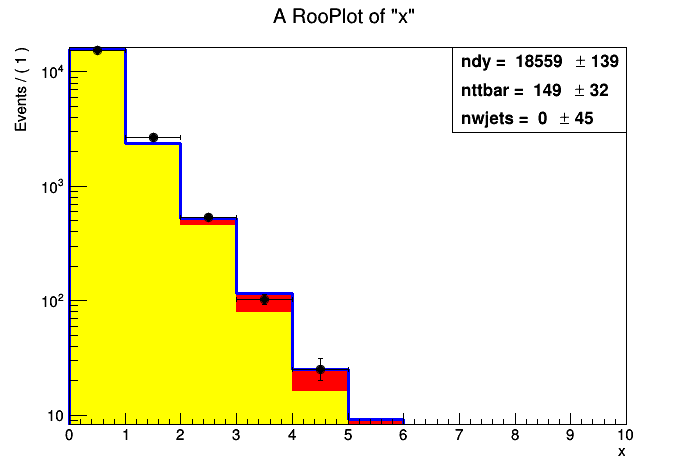

In [18]:
c = TCanvas("c","c",1)
xframe = x.frame() 
data.plotOn(xframe)
model.paramOn(xframe, ROOT.RooFit.Layout(0.65,0.9,0.9) )
model.plotOn(xframe,ROOT.RooFit.Components("pdf_wjets,pdf_dy,pdf_ttbar"),ROOT.RooFit.LineColor(2),ROOT.RooFit.FillColor(2),ROOT.RooFit.DrawOption("F")) 
model.plotOn(xframe,ROOT.RooFit.Components("pdf_wjets,pdf_dy"),ROOT.RooFit.LineColor(5),ROOT.RooFit.FillColor(5),ROOT.RooFit.DrawOption("F")) 
model.plotOn(xframe,ROOT.RooFit.Components("pdf_wjets"),ROOT.RooFit.LineColor(3),ROOT.RooFit.FillColor(3),ROOT.RooFit.DrawOption("F")) 
model.plotOn(xframe)
data.plotOn(xframe)
xframe.Draw()
c.SetLogy()
c.Draw()

##### task

Can you wriate a macro to fit again including single_top process this time?